# Classification

In [1]:
# Run this code to make Jupyter print every
# printable statement and not just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# To visualize the data
import matplotlib.pyplot as plt

# Generic libraries
import seaborn as sns
import pandas as pd
import numpy as np

# Regression models
import sklearn
import scipy
from scipy.stats import *
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV #split the data into training and test
from sklearn.linear_model import LinearRegression #linear regression
from sklearn.preprocessing import PolynomialFeatures #for polynomial regression
from sklearn.metrics import r2_score, mean_squared_error

# 5-folds crossvalidation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline

In [2]:
training_set = pd.read_csv("training_set_complete.csv")
test_set = pd.read_csv("test_set_complete.csv")
training_set = training_set.drop(columns=['Unnamed: 0'])
test_set = test_set.drop(columns=['Unnamed: 0'])
training_set['Revenue'] = training_set['Revenue'].astype(int)
test_set['Revenue'] = test_set['Revenue'].astype(int)
training_set['Revenue'].value_counts()
test_set['Revenue'].value_counts()


0    7807
1    1441
Name: Revenue, dtype: int64

0    2615
1     467
Name: Revenue, dtype: int64

## Logistic regression

In [3]:
X_train_full = training_set.drop(columns=['Revenue'])
X_test_full = test_set.drop(columns=['Revenue'])
y_train = training_set['Revenue']
y_test = test_set['Revenue']

In [4]:
# FACCIAMO QUESTO STEP PER EVITARE PROBLEMI DI CONVERGENZA NEL MODELLO
from sklearn.preprocessing import StandardScaler

# Assuming you have your feature data X
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_full))
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test_full))
X_train_scaled.columns = X_train_full.columns
X_test_scaled.columns = X_test_full.columns

We use the solver saga because it's the most suitable for big datasets and supports the l1 penalization.

In [12]:
from sklearn.linear_model import LogisticRegression            # 1- model selection
model = LogisticRegression(solver='saga', penalty='l1',max_iter=1000)      # 2- hyperparams
model.fit(X_train_scaled, y_train)                               # 3- model fitting
y_predict = model.predict(X_test_scaled)                        # 4- model testing

def accuracy(y_pred, y_true):
    return (y_pred == y_true).mean()

print("Train accuracy:", accuracy(y_train, model.predict(X_train_scaled)))
print("Test accuracy:", accuracy(y_test, model.predict(X_test_scaled)))
coefficients = model.coef_
for feature, coef in zip(X_train_scaled.columns, coefficients[0]):
    print(f"{feature}: {coef}")

LogisticRegression(max_iter=1000, penalty='l1', solver='saga')

Train accuracy: 0.8831098615916955
Test accuracy: 0.8890330953926022
Administrative: -0.020095249656039305
Administrative_Duration: 0.0004762730740422591
Informational: 0.06302948840395912
Informational_Duration: -0.0064258774807275185
ProductRelated: 0.04785412008859644
ProductRelated_Duration: 0.1635075492446544
BounceRates: 0.007809911167128145
ExitRates: -0.83364968945604
PageValues: 1.4760367124575553
SpecialDay: -0.016128902829364328
Month_Aug: 0.03844556663668858
Month_Dec: -0.13652017106683206
Month_Feb: -0.18928299724124323
Month_Jul: 0.09334385104792023
Month_June: 0.0
Month_Mar: -0.10488466281801892
Month_May: -0.10283170061506347
Month_Nov: 0.3037730993028001
Month_Oct: 0.0392948512610761
Month_Sep: 0.05466200789810293
OperatingSystems_1: -0.054656111326039127
OperatingSystems_2: 0.0869722035865344
OperatingSystems_3: 0.0
OperatingSystems_4: -0.01761219135663984
OperatingSystems_5: 0.001490062273830371
OperatingSystems_6: -0.03526086263625431
OperatingSystems_7: -0.02228956

In [55]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

def get_evaluator(scorer):
    def evaluator(model, X, y, trained=False):
        if not trained:
            model = model.fit(X, y)
        score = scorer(model, X, y)
        return model, score
    return evaluator   

def get_cv_evaluator(scorer, cv=3):
    def evaluator(model, X, y, trained=False):            
        scores = cross_val_score(model, X, y, scoring=scorer, cv=cv)
        if not trained:
            model = model.fit(X, y)
        return model, np.mean(scores)
    
    return evaluator

def get_val_evaluator(scorer, val_size=0.1):
    def evaluator(model, X, y, trained=False):
        X_train_small, X_val, y_train_small, y_val = train_test_split(X, y, 
                                                                      test_size=val_size,
                                                                      random_state=0)
        
        if not trained:
            model = model.fit(X_train_small, y_train_small)
        score = scorer(model, X_val, y_val) 
        
        return model, score
    
    return evaluator

def forward_selection(Xtrain_pd, ytrain, Xtest_pd, ytest,
                      candidates_evaluator, candidates_argbest, # Metric to be used at 2.b
                      subsets_evaluator, subsets_argbest,       # Metric to be used at 3
                      test_evaluator=None, test_argbest=None,
                      candidates_scorer_name=None,  # Name of 2. figure
                      subsets_scorer_name=None,     # Name of 3. figure
                      verbose=True, weight_step3=0):   
    test_evaluator = subsets_evaluator if not test_evaluator else test_evaluator
    test_argbest = subsets_argbest if not test_argbest else test_argbest
    
    # Global variable init
    # ====================
    num_features = Xtrain_pd.shape[-1]
    best_candidate_metric = []
    # subsets_* are lists containing one value for each Mk model (the best of the Mk candidates)
    subsets_test = []
    subsets_metric = []        # The best metric of each subset of dimension 'dim'
    subsets_best_features = [] # The best features combination in each subset of dimension 'dim'
    # A figure to keep track of candidates scores in each Mk subset
    plt.figure()
    candidate_fig = plt.subplot(111) # A global matplotlib figure
    num_evaluations = 0        # A conter to keep track of the total number of trials
    
    selected_features = []
    all_features = Xtrain_pd.columns
    
    
    # 1. Train M0
    # ===========
    model = DummyRegressor()
    # Compute (2.b) metrics
    model, score = candidates_evaluator(model, Xtrain_pd[[]], ytrain)
    best_candidate_metric.append(score)
    subsets_best_features.append([])
    _ = candidate_fig.scatter([0], [score], color="b")
    # Compute metric for step 3.
    _, score = subsets_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_metric.append(score)
    _, score = test_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_test.append(score)
    
    # 2. Evaluate all Mk candidates with
    #    k=0...P features
    # =========================================
    for dim in range(num_features):
        candidate_metrics = [] # Keep track of candidates metrics. Will be used to select the best
        candidate_models = []  # Keep track of candidates trained models
        
        # 2.a Fixed the number of features 'dim', look at
        #     all the possible candidate models with that
        #     cardinality
        # ===============================================
        remaining_features = all_features.difference(selected_features)
        
        for new_column in remaining_features:
            Xtrain_sub = Xtrain_pd[selected_features+[new_column]].to_numpy()
            # //==========================================\\
            # || ***** Difference from previous lab ***** ||
            # \\==========================================//
            model = LogisticRegression(solver="saga", penalty='l1',max_iter=1000)
            model, score = candidates_evaluator(model, Xtrain_sub, ytrain)
            candidate_models.append(model)
            candidate_metrics.append(score)
            num_evaluations += 1
            
        _ = candidate_fig.scatter([Xtrain_sub.shape[-1]]*len(candidate_metrics), candidate_metrics,
                                  color="b")
            
        # 2.b Select the best candidate among those using
        #     the same number of features (2.a)
        # ===============================================
        idx_best_candidate = candidates_argbest(candidate_metrics)
        # Update selected feature
        selected_features.append(remaining_features[idx_best_candidate])
        # Save best candidate features
        best_candidate_metric.append(candidate_metrics[idx_best_candidate])
        best_features = selected_features.copy()
        subsets_best_features.append(best_features)
        
        
        # Compute metric for step 3.
        best_subset_model = candidate_models[idx_best_candidate]
        best_subset_Xtrain = Xtrain_pd[best_features].to_numpy()
        best_subset_Xtest = Xtest_pd[best_features].to_numpy()
        _, score = test_evaluator(best_subset_model, best_subset_Xtest, ytest, trained=True)
        subsets_test.append(score)
        _, score = subsets_evaluator(best_subset_model, best_subset_Xtrain, ytrain, trained=True)
        subsets_metric.append(score)
        num_evaluations += weight_step3 
        
        if verbose:
            print("............")
            print("Best model (M{}) with {} features: {}".format(dim+1, dim+1, best_features))
            print("M{} subset score (3.): {}".format(dim+1, score))
        
    # 3. Among all best candidates with increasing number
    #    of features, select the best one
    # ===================================================
    best_subset_idx = subsets_argbest(subsets_metric)
    best_features = subsets_best_features[best_subset_idx]
    
    if verbose:
        print("\n Best configuration has {} features".format(best_subset_idx))
        print("Features: {}".format(subsets_best_features[best_subset_idx]))
        print("Total number of trained models:", num_evaluations)
    
    # Complete the subsets_fig figure by plotting
    # a line connecting all best candidate score
    best_candidate_score_idx = candidates_argbest(best_candidate_metric)
    _ = candidate_fig.plot(range(len(best_candidate_metric)), best_candidate_metric)
    _ = candidate_fig.scatter(best_candidate_score_idx, best_candidate_metric[best_candidate_score_idx],
                              marker='X', label="Best", color="r")
    candidate_fig.set_title(candidates_scorer_name)
    candidate_fig.legend()
    
    # Plot a figure to show how te 3. metric evolves
    plt.figure()
    subsets_fig = plt.subplot(111)
    _ = subsets_fig.plot(range(len(subsets_metric)), subsets_metric, label="Selection (3.) scores")
    _ = subsets_fig.scatter(best_subset_idx, subsets_metric[best_subset_idx],
                              marker='X', label="Best (3.) score", color="r")
    best_test_score_idx = test_argbest(subsets_test)
    _ = subsets_fig.plot(range(len(subsets_test)), subsets_test, label="Test scores")
    _ = subsets_fig.scatter(best_test_score_idx, subsets_test[best_test_score_idx],
                              marker='X', label="Best test score", color="y")
    subsets_fig.set_title(subsets_scorer_name)
    subsets_fig.legend()

............
Best model (M1) with 1 features: ['PageValues']
M1 subset score (3.): 0.8801909441909442
............
Best model (M2) with 2 features: ['PageValues', 'VisitorType_New_Visitor']
M2 subset score (3.): 0.8822451152451153
............
Best model (M3) with 3 features: ['PageValues', 'VisitorType_New_Visitor', 'TrafficType_3']
M3 subset score (3.): 0.8831102141102141
............
Best model (M4) with 4 features: ['PageValues', 'VisitorType_New_Visitor', 'TrafficType_3', 'TrafficType_10']
M4 subset score (3.): 0.8834343044343044
............
Best model (M5) with 5 features: ['PageValues', 'VisitorType_New_Visitor', 'TrafficType_3', 'TrafficType_10', 'Browser_11']
M5 subset score (3.): 0.8834343044343044
............
Best model (M6) with 6 features: ['PageValues', 'VisitorType_New_Visitor', 'TrafficType_3', 'TrafficType_10', 'Browser_11', 'Browser_1']
M6 subset score (3.): 0.8833261963261962
............
Best model (M7) with 7 features: ['PageValues', 'VisitorType_New_Visitor', 'T

............
Best model (M27) with 27 features: ['PageValues', 'VisitorType_New_Visitor', 'TrafficType_3', 'TrafficType_10', 'Browser_11', 'Browser_1', 'Browser_12', 'Browser_9', 'OperatingSystems_5', 'OperatingSystems_7', 'Browser_7', 'TrafficType_11', 'Browser_3', 'Month_Feb', 'OperatingSystems_8', 'TrafficType_5', 'Region_8', 'TrafficType_12', 'TrafficType_16', 'Browser_8', 'TrafficType_14', 'TrafficType_17', 'TrafficType_18', 'TrafficType_7', 'Region_2', 'Browser_13', 'TrafficType_9']
M27 subset score (3.): 0.8837586287586288
............
Best model (M28) with 28 features: ['PageValues', 'VisitorType_New_Visitor', 'TrafficType_3', 'TrafficType_10', 'Browser_11', 'Browser_1', 'Browser_12', 'Browser_9', 'OperatingSystems_5', 'OperatingSystems_7', 'Browser_7', 'TrafficType_11', 'Browser_3', 'Month_Feb', 'OperatingSystems_8', 'TrafficType_5', 'Region_8', 'TrafficType_12', 'TrafficType_16', 'Browser_8', 'TrafficType_14', 'TrafficType_17', 'TrafficType_18', 'TrafficType_7', 'Region_2', '

............
Best model (M40) with 40 features: ['PageValues', 'VisitorType_New_Visitor', 'TrafficType_3', 'TrafficType_10', 'Browser_11', 'Browser_1', 'Browser_12', 'Browser_9', 'OperatingSystems_5', 'OperatingSystems_7', 'Browser_7', 'TrafficType_11', 'Browser_3', 'Month_Feb', 'OperatingSystems_8', 'TrafficType_5', 'Region_8', 'TrafficType_12', 'TrafficType_16', 'Browser_8', 'TrafficType_14', 'TrafficType_17', 'TrafficType_18', 'TrafficType_7', 'Region_2', 'Browser_13', 'TrafficType_9', 'VisitorType_Other', 'OperatingSystems_6', 'Region_6', 'Region_3', 'Region_5', 'VisitorType_Returning_Visitor', 'Browser_4', 'Month_June', 'TrafficType_15', 'TrafficType_20', 'TrafficType_19', 'Region_7', 'OperatingSystems_1']
M40 subset score (3.): 0.8838668538668539
............
Best model (M41) with 41 features: ['PageValues', 'VisitorType_New_Visitor', 'TrafficType_3', 'TrafficType_10', 'Browser_11', 'Browser_1', 'Browser_12', 'Browser_9', 'OperatingSystems_5', 'OperatingSystems_7', 'Browser_7', '

............
Best model (M50) with 50 features: ['PageValues', 'VisitorType_New_Visitor', 'TrafficType_3', 'TrafficType_10', 'Browser_11', 'Browser_1', 'Browser_12', 'Browser_9', 'OperatingSystems_5', 'OperatingSystems_7', 'Browser_7', 'TrafficType_11', 'Browser_3', 'Month_Feb', 'OperatingSystems_8', 'TrafficType_5', 'Region_8', 'TrafficType_12', 'TrafficType_16', 'Browser_8', 'TrafficType_14', 'TrafficType_17', 'TrafficType_18', 'TrafficType_7', 'Region_2', 'Browser_13', 'TrafficType_9', 'VisitorType_Other', 'OperatingSystems_6', 'Region_6', 'Region_3', 'Region_5', 'VisitorType_Returning_Visitor', 'Browser_4', 'Month_June', 'TrafficType_15', 'TrafficType_20', 'TrafficType_19', 'Region_7', 'OperatingSystems_1', 'OperatingSystems_4', 'Browser_5', 'Region_9', 'BounceRates', 'OperatingSystems_2', 'TrafficType_6', 'OperatingSystems_3', 'Browser_10', 'Month_Oct', 'Region_1']
M50 subset score (3.): 0.8835427635427635
............
Best model (M51) with 51 features: ['PageValues', 'VisitorType

............
Best model (M59) with 59 features: ['PageValues', 'VisitorType_New_Visitor', 'TrafficType_3', 'TrafficType_10', 'Browser_11', 'Browser_1', 'Browser_12', 'Browser_9', 'OperatingSystems_5', 'OperatingSystems_7', 'Browser_7', 'TrafficType_11', 'Browser_3', 'Month_Feb', 'OperatingSystems_8', 'TrafficType_5', 'Region_8', 'TrafficType_12', 'TrafficType_16', 'Browser_8', 'TrafficType_14', 'TrafficType_17', 'TrafficType_18', 'TrafficType_7', 'Region_2', 'Browser_13', 'TrafficType_9', 'VisitorType_Other', 'OperatingSystems_6', 'Region_6', 'Region_3', 'Region_5', 'VisitorType_Returning_Visitor', 'Browser_4', 'Month_June', 'TrafficType_15', 'TrafficType_20', 'TrafficType_19', 'Region_7', 'OperatingSystems_1', 'OperatingSystems_4', 'Browser_5', 'Region_9', 'BounceRates', 'OperatingSystems_2', 'TrafficType_6', 'OperatingSystems_3', 'Browser_10', 'Month_Oct', 'Region_1', 'Month_Aug', 'Region_4', 'Month_Sep', 'TrafficType_4', 'TrafficType_8', 'Browser_2', 'Browser_6', 'Weekend_False', 'M

............
Best model (M67) with 67 features: ['PageValues', 'VisitorType_New_Visitor', 'TrafficType_3', 'TrafficType_10', 'Browser_11', 'Browser_1', 'Browser_12', 'Browser_9', 'OperatingSystems_5', 'OperatingSystems_7', 'Browser_7', 'TrafficType_11', 'Browser_3', 'Month_Feb', 'OperatingSystems_8', 'TrafficType_5', 'Region_8', 'TrafficType_12', 'TrafficType_16', 'Browser_8', 'TrafficType_14', 'TrafficType_17', 'TrafficType_18', 'TrafficType_7', 'Region_2', 'Browser_13', 'TrafficType_9', 'VisitorType_Other', 'OperatingSystems_6', 'Region_6', 'Region_3', 'Region_5', 'VisitorType_Returning_Visitor', 'Browser_4', 'Month_June', 'TrafficType_15', 'TrafficType_20', 'TrafficType_19', 'Region_7', 'OperatingSystems_1', 'OperatingSystems_4', 'Browser_5', 'Region_9', 'BounceRates', 'OperatingSystems_2', 'TrafficType_6', 'OperatingSystems_3', 'Browser_10', 'Month_Oct', 'Region_1', 'Month_Aug', 'Region_4', 'Month_Sep', 'TrafficType_4', 'TrafficType_8', 'Browser_2', 'Browser_6', 'Weekend_False', 'M

............
Best model (M74) with 74 features: ['PageValues', 'VisitorType_New_Visitor', 'TrafficType_3', 'TrafficType_10', 'Browser_11', 'Browser_1', 'Browser_12', 'Browser_9', 'OperatingSystems_5', 'OperatingSystems_7', 'Browser_7', 'TrafficType_11', 'Browser_3', 'Month_Feb', 'OperatingSystems_8', 'TrafficType_5', 'Region_8', 'TrafficType_12', 'TrafficType_16', 'Browser_8', 'TrafficType_14', 'TrafficType_17', 'TrafficType_18', 'TrafficType_7', 'Region_2', 'Browser_13', 'TrafficType_9', 'VisitorType_Other', 'OperatingSystems_6', 'Region_6', 'Region_3', 'Region_5', 'VisitorType_Returning_Visitor', 'Browser_4', 'Month_June', 'TrafficType_15', 'TrafficType_20', 'TrafficType_19', 'Region_7', 'OperatingSystems_1', 'OperatingSystems_4', 'Browser_5', 'Region_9', 'BounceRates', 'OperatingSystems_2', 'TrafficType_6', 'OperatingSystems_3', 'Browser_10', 'Month_Oct', 'Region_1', 'Month_Aug', 'Region_4', 'Month_Sep', 'TrafficType_4', 'TrafficType_8', 'Browser_2', 'Browser_6', 'Weekend_False', 'M

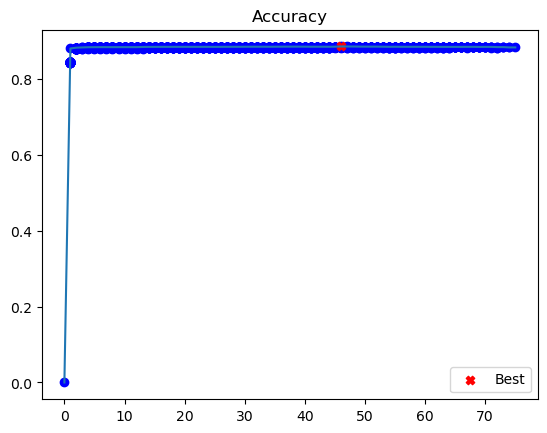

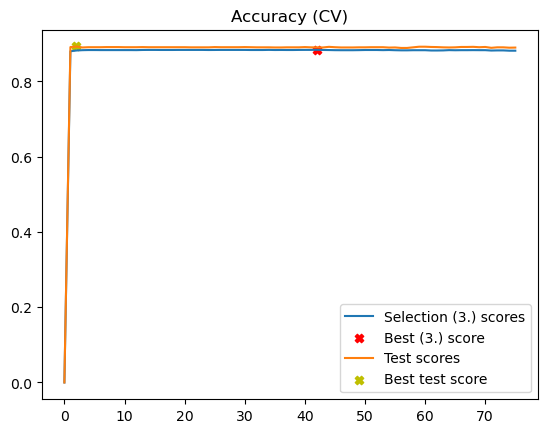

In [56]:
cv = 10
forward_selection(X_train_scaled, y_train, X_test_scaled, y_test,
                  get_evaluator(make_scorer(accuracy)), np.argmax, # 2.
                  get_cv_evaluator(make_scorer(accuracy), cv), np.argmax, # 3.
                  get_evaluator(make_scorer(accuracy)), np.argmax, # test
                  candidates_scorer_name="Accuracy",
                  subsets_scorer_name="Accuracy (CV)",
                  verbose=True, weight_step3=cv)

In [9]:
C_vals = np.linspace(1e-4, 0.5, 100)
betas = []

from sklearn import preprocessing
X_std = preprocessing.scale(X_train_scaled)

for C in C_vals:
    model = LogisticRegression(solver='saga', penalty='l1', C=C,max_iter=1000)
    model.fit(X_std, y_train)
    beta = model.coef_.reshape(-1)
    #beta = (beta - beta.min()) / beta.ptp()
    betas.append(beta)
betas = np.stack(betas, axis=1)  # [Nfeat, NCvals]



LogisticRegression(C=0.0001, max_iter=1000, penalty='l1', solver='saga')

LogisticRegression(C=0.00514949494949495, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.010198989898989898, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.015248484848484848, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.020297979797979798, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.025347474747474747, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.030396969696969697, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.03544646464646465, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.0404959595959596, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.04554545454545455, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.0505949494949495, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.05564444444444445, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.0606939393939394, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.06574343434343434, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.0707929292929293, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.07584242424242425, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.0808919191919192, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.08594141414141414, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.0909909090909091, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.09604040404040405, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.101089898989899, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.10613939393939394, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.11118888888888889, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.11623838383838385, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.12128787878787879, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.12633737373737372, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.13138686868686866, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.13643636363636363, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.14148585858585858, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.14653535353535352, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.1515848484848485, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.15663434343434343, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.16168383838383837, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.16673333333333332, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.17178282828282826, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.17683232323232323, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.18188181818181817, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.18693131313131311, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.19198080808080809, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.19703030303030303, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.20207979797979797, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.2071292929292929, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.21217878787878786, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.21722828282828283, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.22227777777777777, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.2273272727272727, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.23237676767676768, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.23742626262626262, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.24247575757575757, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.2475252525252525, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.25257474747474745, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.2576242424242424, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.26267373737373734, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.2677232323232323, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.2727727272727273, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.2778222222222222, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.28287171717171716, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.28792121212121213, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.29297070707070705, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.298020202020202, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.303069696969697, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.3081191919191919, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.3131686868686869, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.3182181818181818, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.32326767676767676, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.32831717171717173, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.33336666666666664, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.3384161616161616, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.34346565656565653, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.3485151515151515, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.35356464646464647, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.3586141414141414, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.36366363636363636, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.3687131313131313, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.37376262626262624, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.3788121212121212, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.3838616161616162, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.3889111111111111, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.39396060606060607, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.399010101010101, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.40405959595959595, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.4091090909090909, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.41415858585858584, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.4192080808080808, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.4242575757575757, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.4293070707070707, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.43435656565656566, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.4394060606060606, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.44445555555555555, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.4495050505050505, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.45455454545454543, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.4596040404040404, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.4646535353535354, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.4697030303030303, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.47475252525252526, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.4798020202020202, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.48485151515151514, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.4899010101010101, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.49495050505050503, max_iter=1000, penalty='l1',
                   solver='saga')

LogisticRegression(C=0.5, max_iter=1000, penalty='l1', solver='saga')

Text(0.5, 0, 'C=1/lambda')

Text(0, 0.5, 'beta')

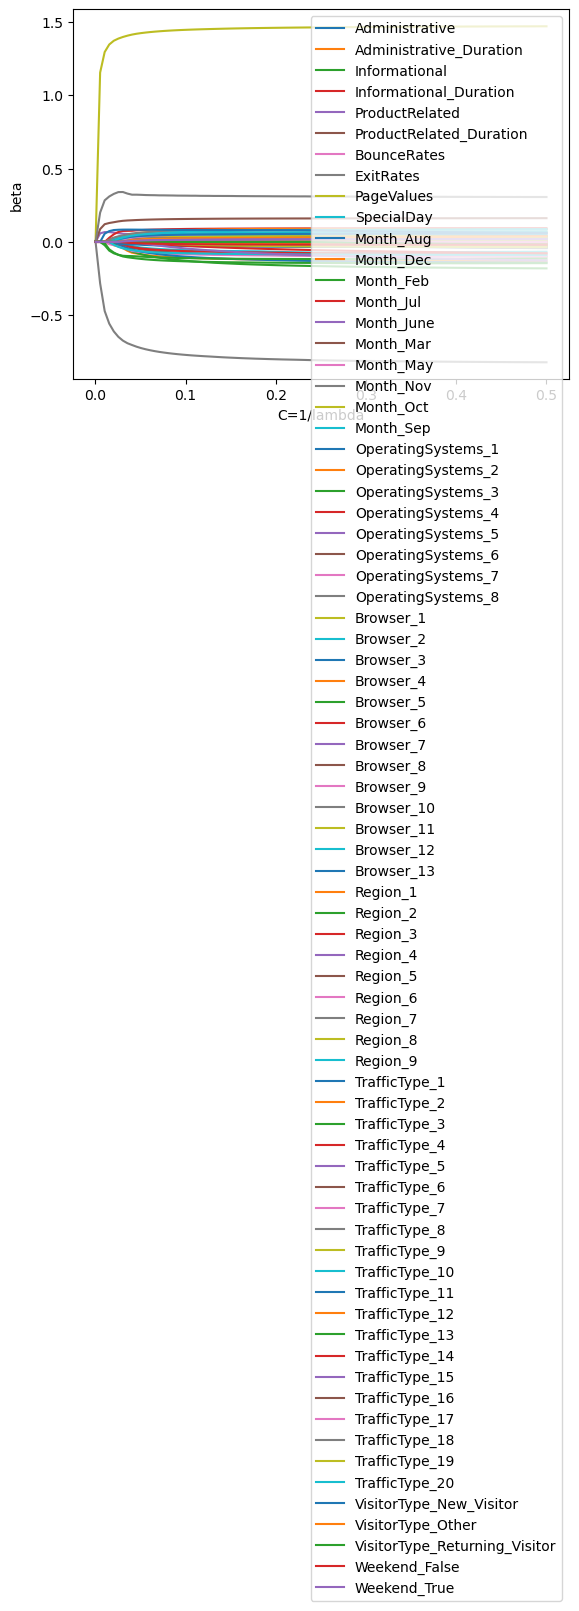

In [10]:
for beta, name in zip(betas, X_train_scaled.columns):
    plt.plot(C_vals, beta, label=name)
plt.legend()
plt.xlabel("C=1/lambda")
plt.ylabel("beta")

# LDA

In [64]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
model = LDA()
model = model.fit(X_train_full, y_train)

print("Train accuracy:", accuracy(y_train, model.predict(X_train_full)))
print("Test accuracy:", accuracy(y_test, model.predict(X_test_full)))

Train accuracy: 0.879757785467128
Test accuracy: 0.8854639844256976


In [65]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

model = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('lda', LDA(store_covariance=True))])
model = model.fit(X_train_full, y_train)

print("Train accuracy:", accuracy(y_train, model.predict(X_train_full)))
print("Test accuracy:", accuracy(y_test, model.predict(X_test_full)))

Train accuracy: 0.9083044982698962
Test accuracy: 0.8828682673588579


In [68]:
from sklearn.model_selection import GridSearchCV

model = Pipeline([('poly', PolynomialFeatures()),
                  ('lda', LDA(store_covariance=True))])
params = {'poly__degree': range(1, 6)}
cv = GridSearchCV(model, params, refit=True, cv=10, 
                  scoring=make_scorer(accuracy))
cv.fit(X_train_full, y_train)

C:\Users\sarar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sarar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sarar\anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\sarar\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py", line 590, in fit
    self._solve_svd(X, y)
  File "C:\Users\sarar\anaconda

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('lda',
                                        LinearDiscriminantAnalysis(store_covariance=True))]),
             param_grid={'poly__degree': range(1, 6)},
             scoring=make_scorer(accuracy))

## QDA

In [99]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
model = QDA(store_covariance=True)
model = model.fit(X_train_full, y_train)

print("Train accuracy:", accuracy(y_train, model.predict(X_train_full)))
print("Test accuracy:", accuracy(y_test, model.predict(X_test_full)))

Train accuracy: 0.18933823529411764
Test accuracy: 0.18397144711226476


C:\Users\sarar\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


## KNN

In [113]:
# Train a KNN with different k values
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=6)
model.fit(X_train_full, y_train)

print("Train accuracy:", accuracy(y_train, model.predict(X_train_full)))
print("Test accuracy:", accuracy(y_test, model.predict(X_test_full)))

KNeighborsClassifier(n_neighbors=6)

C:\Users\sarar\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Train accuracy: 0.8831098615916955
Test accuracy: 0.8754055807916937


C:\Users\sarar\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [112]:
from sklearn.model_selection import GridSearchCV

model = KNeighborsClassifier()
params = {'n_neighbors': range(1, 15)}
cv = GridSearchCV(model, params, refit=True, cv=10, 
                  scoring=make_scorer(accuracy))
cv.fit(X_train_full, y_train)
cv.best_params_

C:\Users\sarar\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\sarar\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\sarar\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\sarar\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\sarar\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\sarar\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\sarar\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\sarar\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\sarar\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\sarar\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\sarar\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\sarar\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\sarar\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\sarar\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\sarar\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\sarar\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\sarar\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\sarar\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 15)},
             scoring=make_scorer(accuracy))

{'n_neighbors': 6}